<a href="https://colab.research.google.com/github/klausgottlieb/crut-monte-carlo-replication/blob/main/notebook_00_foundation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 00 — Foundation and Baseline Scenarios
## *When Do Charitable Remainder Unitrusts Outperform? A Monte Carlo Analysis*
### Klaus Gottlieb, JD, MS, MBA — Wealth Care Lawyer, Cayucos, CA

---

## Disclosure

The simulation engine in this notebook replicates the results and methodology described in the manuscript. It is didtinct from the CalCRUT modeling tool (calcrut2-WCL.pythonanywhere.com), which, however, uses the same underlying methodology and assumptions. The author used large-language model assistance in drafting portions of this code and the associated manuscript text; all outputs have been verified by the author.

---

## Purpose

This notebook establishes the simulation engine, documents all baseline parameters, and reports results for four benchmark portfolio turnover scenarios. It directly addresses peer review by presenting the analysis across the full range of turnover assumptions rather than a single point estimate.

### Why Four Turnover Scenarios?

A reviewer questioned the manuscript's original 60% annual turnover assumption as potentially high for the benchmark portfolio. This revision presents four scenarios spanning the plausible range:

| Scenario | Annual Turnover | Representative of |
|---|---|---|
| A | 0% | Pure buy-and-hold; no annual tax drag (most favorable to benchmark) |
| B | 20% | Moderately active advisor-managed account |
| C | 40% | Actively managed account |
| D | 60% | Aggressively managed account (original manuscript baseline) |

All other parameters are held constant across the four scenarios. Scenario A (0% turnover), while unlikely in practice, is the most favorable assumption for the benchmark. 

---

## Table 1 — Baseline Scenario Parameters

| Parameter | Value | Source / Rationale |
|---|---|---|
| FMV of contributed asset | \$1,000,000 | Round number for illustration |
| Tax basis | 20% of FMV (\$200,000) | Moderately appreciated asset |
| Donor AGI | \$500,000 | Upper-middle high-net-worth |
| Donor ages | 63 / 65 (Two Life) | Typical pre-retirement couple |
| Payout rate | 6% | Common practitioner choice |
| Payment frequency | Quarterly | Standard CRUT terms |
| §7520 rate | 5.0% | Mid-range historical value |
| Federal ordinary rate | 37% | Top marginal bracket |
| OBBBA deduction rate cap | 35% | One Big Beautiful Bill Act — limits deduction benefit to 35¢ per dollar for top-bracket filers |
| Federal LTCG rate | 20% | Top bracket |
| NIIT | 3.8% | IRC §1411 |
| State income tax | 9.3% | California (illustrative) |
| AGI deduction limit | 30% | IRC §170(b)(1)(C) for capital gain property |
| Carryforward period | 5 years | IRC §170(d)(1) |
| Trust / benchmark fee | 1.0% | Typical institutional rate |
| **Benchmark turnover** | **0% / 20% / 40% / 60%** | **Four scenarios — see above** |
| Expected return μ | 7% | Long-run equity real return estimate |
| Return volatility σ | 12% | Moderate equity volatility |
| Return model | Gaussian (lognormal) | Notebook 05 shows robustness |
| Simulation paths | 2,000 | Sufficient for 95% CI |
| Random seed | 42 | Replication |

---

## Figures produced:
1. CRUT corpus fan charts — four scenarios
2. Benchmark portfolio fan charts — four scenarios
3. Terminal net benefit distributions — four scenarios overlaid
4. Cumulative distribution functions — four scenarios
5. Annual after-tax distributions — four scenarios
6. Win probability summary — four scenarios with 95% CI
7. Parameter documentation table

---

In [1]:
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install',
                       'numpy', 'matplotlib', 'scipy', '--quiet'])
print('Dependencies confirmed.')

Dependencies confirmed.


In [2]:
from dataclasses import dataclass, replace
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams.update({
    'figure.dpi': 120,
    'font.family': 'sans-serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white',
})

# Four scenario definitions — all other parameters identical
SCENARIOS = [
    {'turnover': 0.00, 'label': 'Scenario A: 0% turnover',  'color': '#08306b', 'ls': '-'},
    {'turnover': 0.20, 'label': 'Scenario B: 20% turnover', 'color': '#2171b5', 'ls': '-'},
    {'turnover': 0.40, 'label': 'Scenario C: 40% turnover', 'color': '#fd8d3c', 'ls': '--'},
    {'turnover': 0.60, 'label': 'Scenario D: 60% turnover', 'color': '#d73027', 'ls': '--'},
]
print('Imports complete. Four scenarios defined.')

Imports complete. Four scenarios defined.


In [3]:
# =============================================================================
# COMPLETE SIMULATION ENGINE
# =============================================================================

IRS_LIFE_EXPECTANCY = {
    35: 48.3, 40: 43.6, 45: 38.9, 50: 34.2, 55: 29.6,
    60: 25.2, 61: 24.4, 62: 23.5, 63: 22.7, 64: 21.8,
    65: 21.0, 66: 20.2, 67: 19.4, 68: 18.6, 69: 17.8,
    70: 17.0, 71: 16.3, 72: 15.5, 73: 14.8, 74: 14.1,
    75: 13.4, 76: 12.7, 77: 12.1, 78: 11.4, 79: 10.8,
    80: 10.2, 85: 7.3,  90: 5.0
}

def get_life_expectancy(age):
    if age in IRS_LIFE_EXPECTANCY:
        return IRS_LIFE_EXPECTANCY[age]
    ages = sorted(IRS_LIFE_EXPECTANCY.keys())
    for i in range(len(ages) - 1):
        if ages[i] < age < ages[i+1]:
            a1, a2 = ages[i], ages[i+1]
            return (IRS_LIFE_EXPECTANCY[a1]
                    + (IRS_LIFE_EXPECTANCY[a2] - IRS_LIFE_EXPECTANCY[a1])
                    * (age - a1) / (a2 - a1))
    raise ValueError(f'Age {age} out of range')

def get_joint_life_expectancy(age1, age2):
    e1, e2 = get_life_expectancy(age1), get_life_expectancy(age2)
    return e1 + e2 - 1.0 / (1.0/e1 + 1.0/e2)

def compute_deduction(fmv, payout_rate, rate_7520, life_type,
                      age1=65, age2=None, term_years=20,
                      freq=4, lag_months=0, longevity_adj=0):
    """
    Compute CRUT charitable deduction using IRS Reg. 1.664-4 method.
    Table F adjustment: rate_7520 / (freq * ((1+rate_7520)^(1/freq) - 1))
    For 5% rate quarterly: table_f ~ 1.0186, adjusted payout ~ 6.11%.
    R must be >= 10% (IRC 664 charitable remainder requirement).
    """
    i, p = rate_7520, payout_rate
    table_f         = i / (freq * ((1 + i) ** (1/freq) - 1))
    adjusted_payout = p * table_f
    if life_type == 'Term of Years':
        irs_duration = float(term_years)
    elif life_type == 'Single Life':
        irs_duration = get_life_expectancy(age1)
    else:
        irs_duration = get_joint_life_expectancy(age1, age2)
    R = max(0.0, min(1.0, (1 - adjusted_payout) ** irs_duration))
    return {
        'deduction': fmv * R, 'remainder_factor': R,
        'compliance': R >= 0.10, 'irs_duration': irs_duration,
        'sim_horizon': irs_duration + longevity_adj,
    }

def generate_return_paths(mu, sigma, n_years, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mu_log    = np.log(1 + mu) - 0.5 * (sigma / (1 + mu)) ** 2
    sigma_log = sigma / (1 + mu)
    return np.exp(np.random.normal(mu_log, sigma_log, size=(n_paths, n_years)))

@dataclass
class ScenarioParams:
    fmv:               float        = 1_000_000
    basis_pct:         float        = 0.20
    agi:               float        = 500_000
    payout_rate:       float        = 0.06
    life_type:         str          = 'Two Life'
    age1:              int          = 63
    age2:              Optional[int]= 65
    term_years:        int          = 20
    freq:              int          = 4
    lag_months:        int          = 0
    longevity_adj:     int          = 0
    rate_7520:         float        = 0.05
    pv_rate:           float        = 0.05
    fed_ordinary:      float        = 0.37
    fed_ltcg:          float        = 0.20
    niit:              float        = 0.038
    state_rate:        float        = 0.093
    agi_limit_pct:     float        = 0.30
    carryforward_years:int          = 5
    trust_fee:         float        = 0.01
    bench_fee:         float        = 0.01
    turnover:          float        = 0.20   # DEFAULT: 20% (conservative)
    mu:                float        = 0.07
    sigma:             float        = 0.12
    n_paths:           int          = 2000
    seed:              int          = 42

def run_simulation(params, step_up=False):
    """
    Run paired-path Monte Carlo simulation.
    step_up=True applies IRC §1014 to benchmark terminal value.
    """
    p = params
    ded_res = compute_deduction(
        fmv=p.fmv, payout_rate=p.payout_rate, rate_7520=p.rate_7520,
        life_type=p.life_type, age1=p.age1, age2=p.age2,
        term_years=p.term_years, freq=p.freq, lag_months=p.lag_months,
        longevity_adj=p.longevity_adj,
    )
    T           = int(round(ded_res['sim_horizon']))
    deduction   = ded_res['deduction']
    tau_ord     = p.fed_ordinary + p.state_rate
    tau_cg      = p.fed_ltcg + p.niit + p.state_rate
    combined_ord= min(p.fed_ordinary, 0.35) + p.state_rate  # OBBBA: deduction benefit capped at 35% for top-bracket filers

    # Deduction tax benefit (absorbed over 6 years)
    annual_limit = p.agi * p.agi_limit_pct
    remaining    = deduction
    pv_tax       = 0.0
    for yr in range(p.carryforward_years + 1):
        usable = min(remaining, annual_limit)
        if usable <= 0:
            break
        pv_tax   += usable * combined_ord / (1 + p.pv_rate) ** yr
        remaining -= usable

    # Paired return paths (same sequence for both strategies)
    returns = generate_return_paths(p.mu, p.sigma, T, p.n_paths, seed=p.seed)

    # CRUT simulation
    crut_v = np.full(p.n_paths, p.fmv)
    dists  = np.zeros((p.n_paths, T))
    for t in range(T):
        v          = crut_v * (1 - p.trust_fee) * returns[:, t]
        d          = v * p.payout_rate
        dists[:, t]= d * (1 - tau_ord)
        crut_v     = np.maximum(0, v - d)

    # Benchmark simulation
    bench_v    = np.full(p.n_paths, p.fmv)
    bench_basis= p.fmv * p.basis_pct
    for t in range(T):
        b          = bench_v * (1 - p.bench_fee) * returns[:, t]
        gain       = np.maximum(0, b - bench_basis)
        tax_drag   = p.turnover * gain * tau_cg
        bench_v    = np.maximum(0, b - tax_drag)
        bench_basis= bench_basis + p.turnover * gain * (1 - tau_cg)

    # PV of CRUT wealth
    disc        = np.array([(1 + p.pv_rate) ** -(t+1) for t in range(T)])
    crut_wealth = (dists * disc).sum(axis=1) + pv_tax

    # PV of benchmark wealth
    term_gain   = np.maximum(0, bench_v - bench_basis)
    bench_term  = bench_v if step_up else bench_v - term_gain * tau_cg
    bench_wealth= bench_term / (1 + p.pv_rate) ** T

    delta = crut_wealth - bench_wealth
    return {
        'deduction_res':  ded_res,
        'crut_paths':     None,          # not stored to save memory
        'bench_paths':    None,
        'returns':        returns,
        'crut_v_final':   crut_v,
        'bench_v_final':  bench_v,
        'dists':          dists,
        'crut_wealth':    crut_wealth,
        'bench_wealth':   bench_wealth,
        'delta_wealth':   delta,
        'win_prob':       float(np.mean(delta > 0)),
        'median_delta':   float(np.median(delta)),
        'pv_tax':         pv_tax,
        'T':              T,
        'params':         p,
    }

def bootstrap_ci(data, stat_fn, n_boot=1000, ci=0.95, seed=0):
    rng  = np.random.RandomState(seed)
    n    = len(data)
    boot = [stat_fn(rng.choice(data, size=n, replace=True)) for _ in range(n_boot)]
    alpha = 1 - ci
    return (float(np.percentile(boot, 100*alpha/2)),
            float(np.percentile(boot, 100*(1-alpha/2))))

print('Engine loaded.')

Engine loaded.


In [4]:
# =============================================================================
# RUN ALL FOUR SCENARIOS
# =============================================================================

base_params = ScenarioParams()   # turnover=0.20 default; overridden per scenario
scenario_results = {}

print('Running four baseline scenarios...')
print()
print(f'{"Scenario":<35} {"Win prob":>10} {"95% CI":>20} {"Median $":>12} {"Horizon":>8}')
print('-' * 90)

for sc in SCENARIOS:
    p   = replace(base_params, turnover=sc['turnover'])
    r   = run_simulation(p)
    lo, hi = bootstrap_ci(r['delta_wealth'], lambda x: np.mean(x > 0))
    scenario_results[sc['turnover']] = r
    scenario_results[sc['turnover']]['ci'] = (lo, hi)
    print(f"{sc['label']:<35} "
          f"{r['win_prob']*100:>9.1f}%  "
          f"[{lo*100:.1f}%–{hi*100:.1f}%]  "
          f"${r['median_delta']:>10,.0f}  "
          f"{r['T']:>6} yr")

print()
print('All four scenarios complete.')

Running four baseline scenarios...

Scenario                              Win prob               95% CI     Median $  Horizon
------------------------------------------------------------------------------------------
Scenario A: 0% turnover                  25.8%  [23.8%–27.6%]  $  -184,046      33 yr
Scenario B: 20% turnover                 54.3%  [52.0%–56.6%]  $    19,397      33 yr
Scenario C: 40% turnover                 62.4%  [60.2%–64.6%]  $    51,876      33 yr
Scenario D: 60% turnover                 66.4%  [64.2%–68.5%]  $    65,899      33 yr

All four scenarios complete.


---
## Section 1 — CRUT and Benchmark Corpus Fan Charts

### Figures 1–2: Fan Charts

Fan charts show the 10th, 25th, 50th, 75th, and 90th percentile paths of the CRUT corpus (Figure 1) and benchmark portfolio (Figure 2) across the four turnover scenarios. The CRUT corpus is identical across scenarios — turnover affects only the benchmark. This makes the comparison visually clear: the left panel is unchanged; the right panel fans out as turnover decreases because higher turnover erodes the benchmark through annual tax drag.

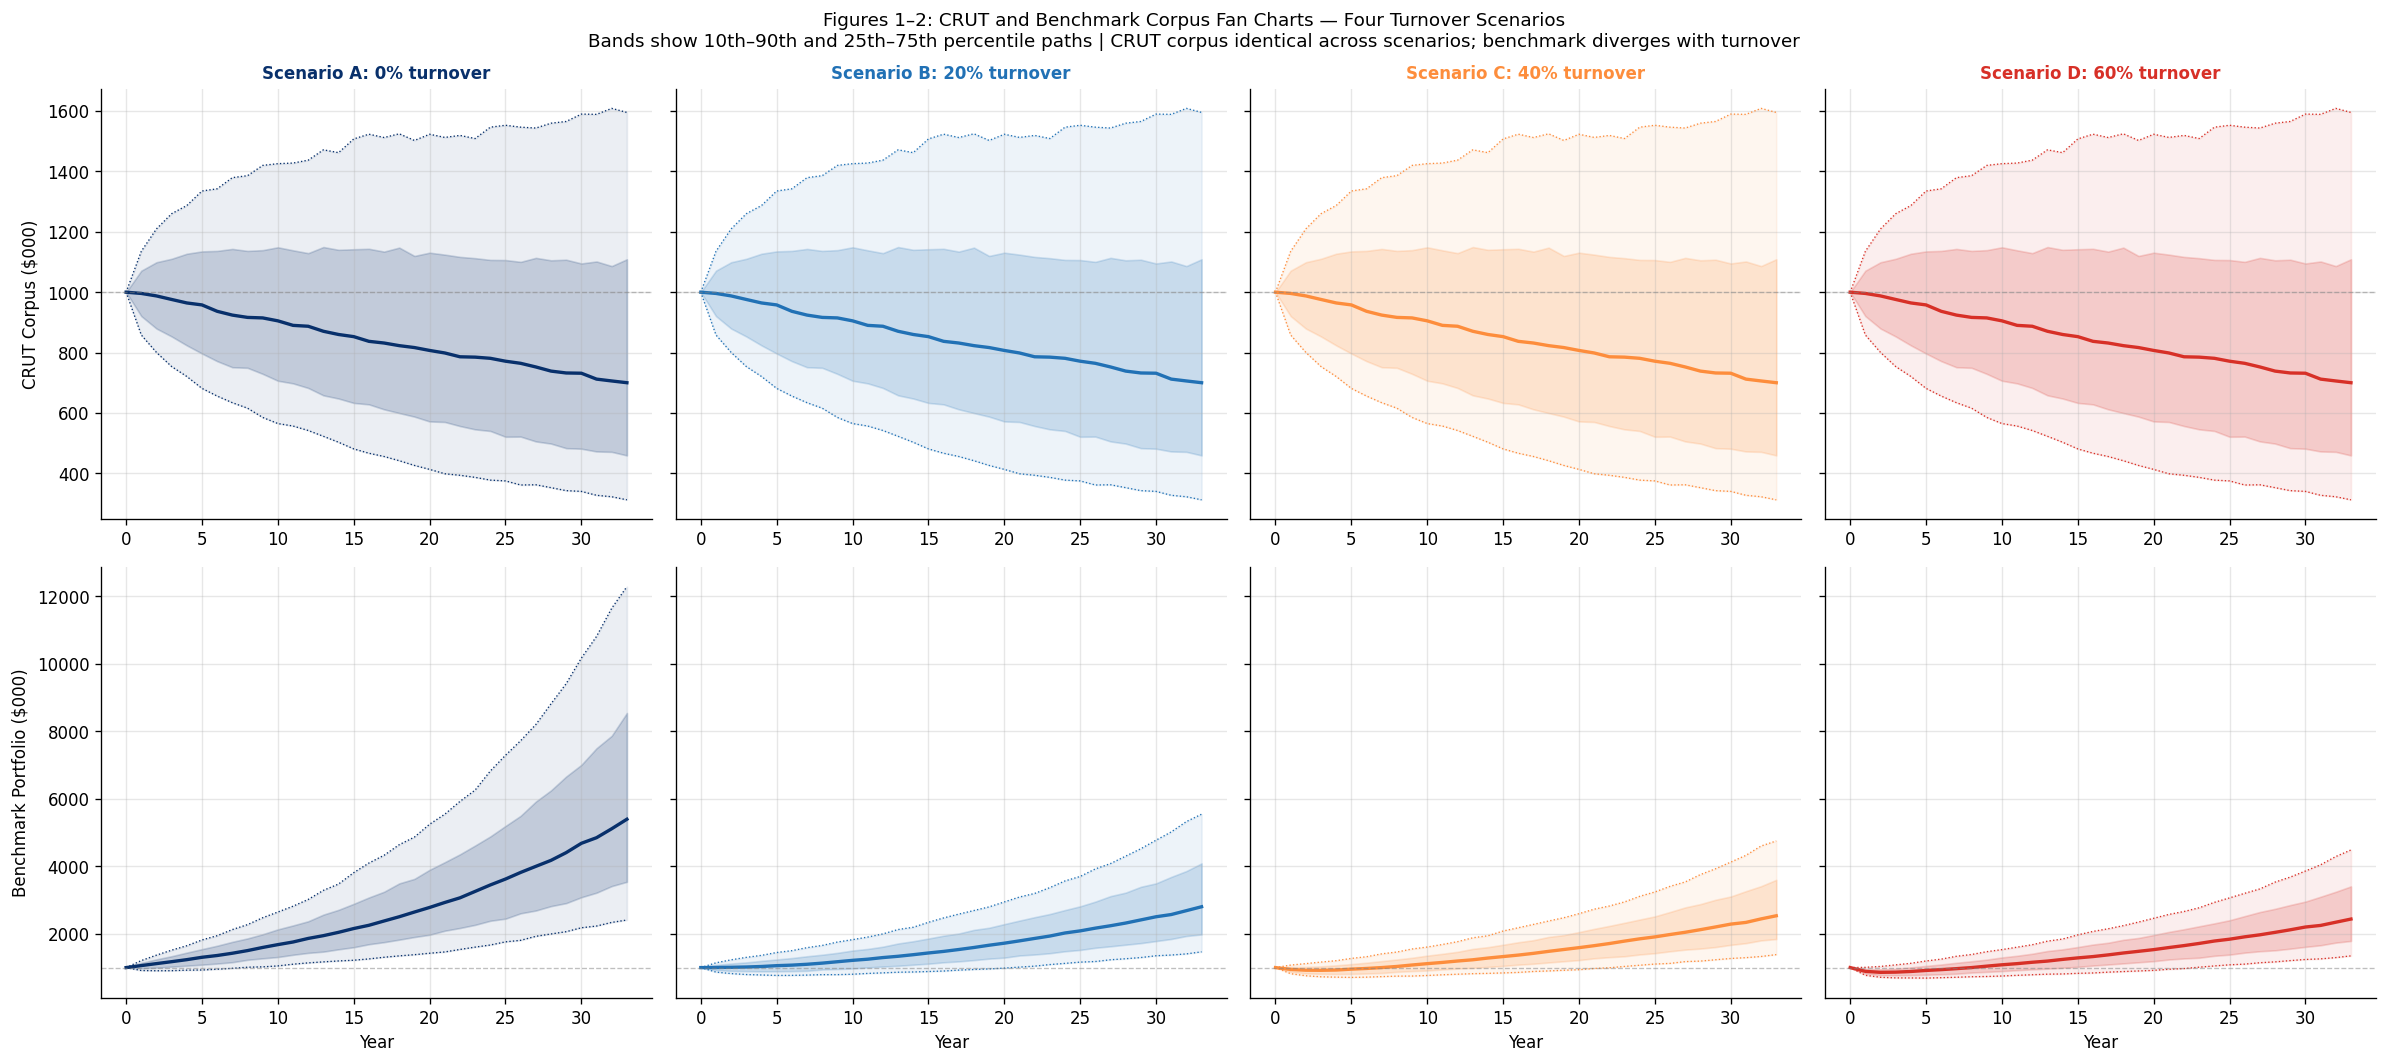

Figures 1-2 saved.


In [5]:
# --- Figures 1-2: Fan charts ---
# We re-run with stored return paths to get year-by-year corpus.
# CRUT is the same for all scenarios (turnover doesn't affect trust corpus).

percentiles = [10, 25, 50, 75, 90]
alphas      = [0.10, 0.20, 0.35, 0.20, 0.10]

def compute_annual_paths(p):
    """Return year-by-year CRUT and benchmark corpus arrays."""
    ded_res = compute_deduction(
        fmv=p.fmv, payout_rate=p.payout_rate, rate_7520=p.rate_7520,
        life_type=p.life_type, age1=p.age1, age2=p.age2,
        longevity_adj=p.longevity_adj,
    )
    T       = int(round(ded_res['sim_horizon']))
    tau_ord = p.fed_ordinary + p.state_rate
    tau_cg  = p.fed_ltcg + p.niit + p.state_rate
    returns = generate_return_paths(p.mu, p.sigma, T, p.n_paths, seed=p.seed)

    crut_paths  = np.zeros((p.n_paths, T+1))
    bench_paths = np.zeros((p.n_paths, T+1))
    crut_paths[:, 0]  = p.fmv
    bench_paths[:, 0] = p.fmv
    bench_basis       = p.fmv * p.basis_pct

    for t in range(T):
        v = crut_paths[:, t] * (1 - p.trust_fee) * returns[:, t]
        d = v * p.payout_rate
        crut_paths[:, t+1] = np.maximum(0, v - d)

        b    = bench_paths[:, t] * (1 - p.bench_fee) * returns[:, t]
        gain = np.maximum(0, b - bench_basis)
        tax_drag = p.turnover * gain * tau_cg
        bench_paths[:, t+1] = np.maximum(0, b - tax_drag)
        bench_basis = bench_basis + p.turnover * gain * (1 - tau_cg)

    return crut_paths, bench_paths, T

fig, axes = plt.subplots(2, 4, figsize=(20, 9), sharey='row')

for col, sc in enumerate(SCENARIOS):
    p     = replace(base_params, turnover=sc['turnover'])
    crut_p, bench_p, T = compute_annual_paths(p)
    years = np.arange(T+1)
    color = sc['color']

    for row, (paths, title_suffix) in enumerate([
        (crut_p,  'CRUT Corpus'),
        (bench_p, 'Benchmark Portfolio'),
    ]):
        ax = axes[row][col]
        pcts = np.percentile(paths, percentiles, axis=0) / 1000

        ax.fill_between(years, pcts[0], pcts[4], alpha=0.08, color=color)
        ax.fill_between(years, pcts[1], pcts[3], alpha=0.18, color=color)
        ax.plot(years, pcts[2], color=color, lw=2, label='Median')
        ax.plot(years, pcts[0], color=color, lw=0.8, ls=':')
        ax.plot(years, pcts[4], color=color, lw=0.8, ls=':')
        ax.axhline(p.fmv/1000, color='gray', lw=0.8, ls='--', alpha=0.5)

        if row == 0:
            ax.set_title(sc['label'], fontsize=10, fontweight='bold', color=color)
        ax.set_xlabel('Year' if row == 1 else '')
        ax.set_ylabel('Corpus ($000)' if col == 0 else '')
        side_label = 'CRUT Corpus' if row == 0 else 'Benchmark Portfolio'
        if col == 0:
            ax.set_ylabel(f'{side_label} ($000)', fontsize=10)

fig.suptitle(
    'Figures 1–2: CRUT and Benchmark Corpus Fan Charts — Four Turnover Scenarios\n'
    'Bands show 10th–90th and 25th–75th percentile paths | '
    'CRUT corpus identical across scenarios; benchmark diverges with turnover',
    fontsize=11
)
plt.tight_layout()
plt.savefig('fig1_2_fan_charts.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figures 1-2 saved.')

---
## Section 2 — Terminal Net Benefit Distributions

### Figure 3: Overlaid Histograms

The terminal net benefit (CRUT wealth minus benchmark wealth) distribution is plotted for all four scenarios on the same axes. Moving from Scenario D (60% turnover) to Scenario A (0% turnover), the distribution shifts leftward — the benchmark becomes more competitive as turnover decreases because less annual tax drag accumulates.

The vertical dashed lines show the median for each scenario. The key question is not just whether the median is positive, but how the win probability (fraction of paths to the right of zero) changes across scenarios.

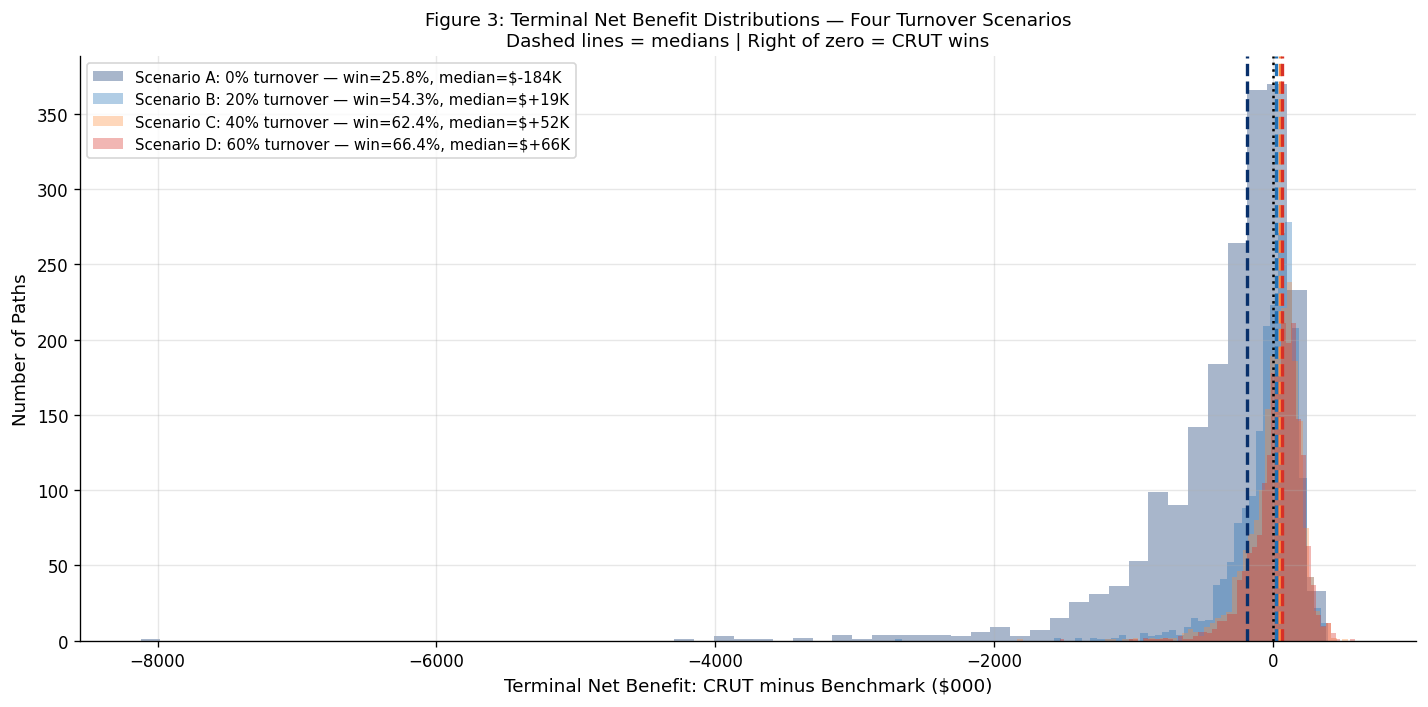

Figure 3 saved.


In [6]:
# --- Figure 3: Terminal net benefit distributions — four scenarios ---

fig, ax = plt.subplots(figsize=(12, 6))

for sc in SCENARIOS:
    r     = scenario_results[sc['turnover']]
    delta = r['delta_wealth'] / 1000
    wp    = r['win_prob']
    med   = r['median_delta'] / 1000
    ax.hist(delta, bins=60, alpha=0.35, color=sc['color'],
            label=f"{sc['label']} — win={wp:.1%}, median=${med:+.0f}K")
    ax.axvline(med, color=sc['color'], lw=2, ls='--')

ax.axvline(0, color='black', lw=1.5, ls=':')
ax.set_xlabel('Terminal Net Benefit: CRUT minus Benchmark ($000)', fontsize=11)
ax.set_ylabel('Number of Paths', fontsize=11)
# Clip x-axis and disclose truncation
all_deltas = np.concatenate([scenario_results[sc['turnover']]['delta_wealth'] / 1000
                             for sc in SCENARIOS])
n_hidden   = int(np.sum(all_deltas < -2000))
pct_hidden = n_hidden / len(all_deltas) * 100
ax.set_xlim(-2000, 500)
ax.legend(fontsize=9)
ax.set_title(
    'Figure 3: Terminal Net Benefit Distributions — Four Turnover Scenarios\n'
    'Dashed lines = medians | Right of zero = CRUT wins\n'
    f'Note: {pct_hidden:.1f}% of paths (left tail below −$2,000K) not shown',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig3_terminal_distributions.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 3 saved.')

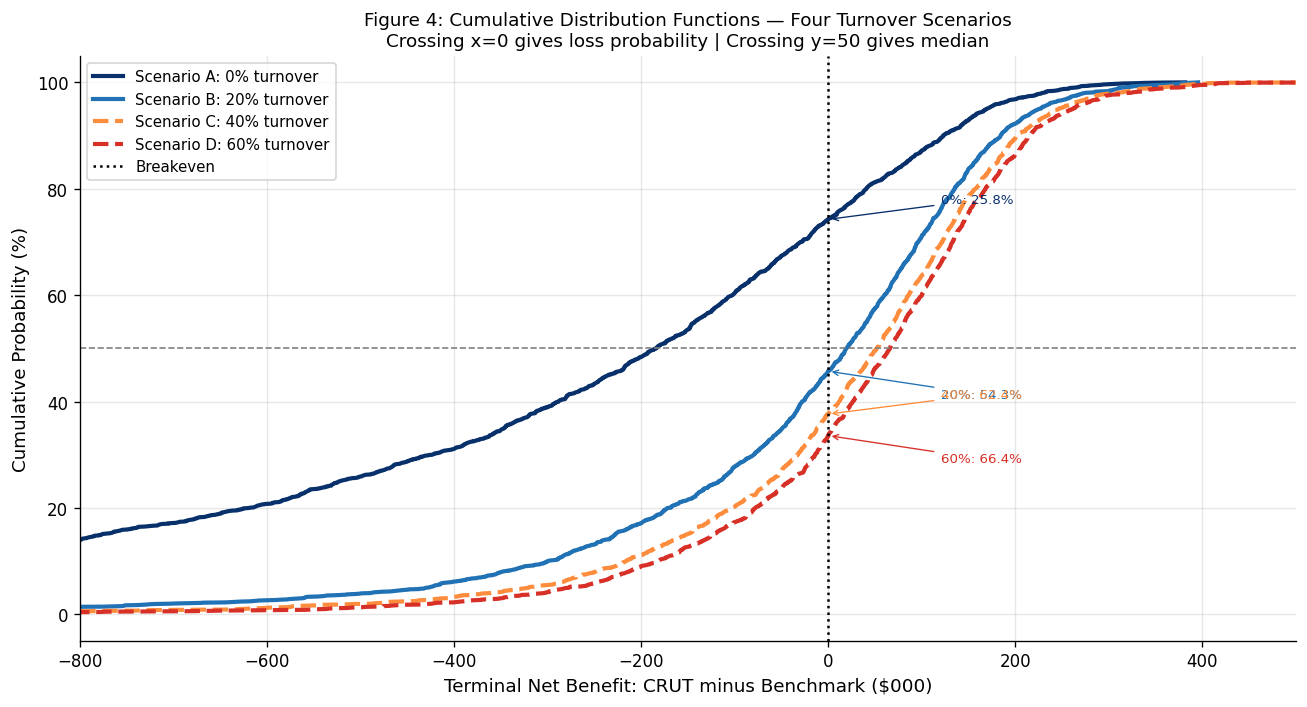

Figure 4 saved.


In [7]:
# --- Figure 4: CDFs — four scenarios ---
# The CDF is often more informative than the histogram for comparing
# distributions. The 50% crossover on the x-axis shows each scenario's median;
# the x=0 crossover shows the loss probability (1 - win probability).

fig, ax = plt.subplots(figsize=(11, 6))

for sc in SCENARIOS:
    r     = scenario_results[sc['turnover']]
    delta = np.sort(r['delta_wealth']) / 1000
    cdf   = np.arange(1, len(delta)+1) / len(delta)
    wp  = scenario_results[sc['turnover']]['win_prob']
    med = scenario_results[sc['turnover']]['median_delta'] / 1000
    ax.plot(delta, cdf * 100, color=sc['color'], lw=2.5,
            ls=sc['ls'],
            label=f"{sc['label']}  |  win={wp:.1%}, median=${med:+.0f}K")

ax.axvline(0,  color='black', lw=1.5, ls=':', label='Breakeven')
ax.axhline(50, color='gray',  lw=1,   ls='--')


ax.set_xlabel('Terminal Net Benefit: CRUT minus Benchmark ($000)', fontsize=11)
ax.set_ylabel('Cumulative Probability (%)', fontsize=11)
ax.set_title(
    'Figure 4: Cumulative Distribution Functions — Four Turnover Scenarios\n'
    'Crossing x=0 gives loss probability | Crossing y=50 gives median',
    fontsize=11
)
ax.legend(fontsize=9)
ax.set_xlim(-800, 500)
plt.tight_layout()
plt.savefig('fig4_cdfs.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 4 saved.')

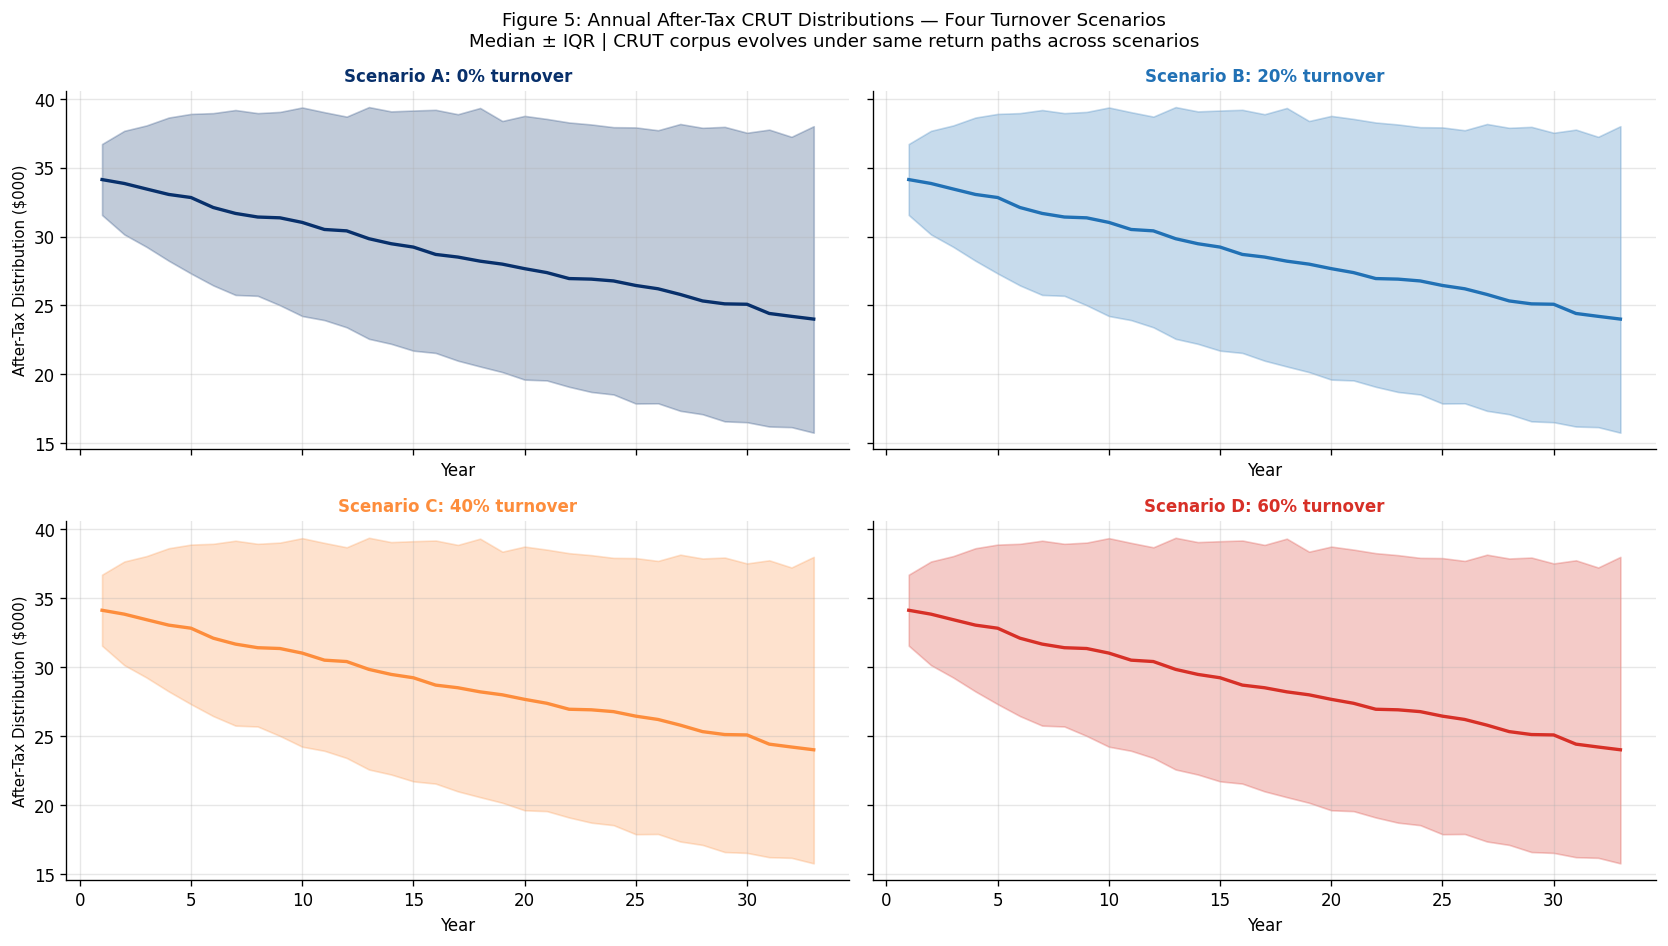

Figure 5 saved.


In [8]:
# --- Figure 5: Annual after-tax distributions — four scenarios ---
# Shows median annual income from the CRUT vs. benchmark across years.
# CRUT distribution is identical across scenarios.
# Benchmark income (dividends/interest net of tax) is approximately
# proxied here as zero since we model total return; the key is the
# CRUT distribution stream, which is the primary income source.

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True, sharex=True)

for idx, sc in enumerate(SCENARIOS):
    ax  = axes[idx // 2][idx % 2]
    p   = replace(base_params, turnover=sc['turnover'])
    _, _, T = compute_annual_paths(p)
    returns = generate_return_paths(p.mu, p.sigma, T, p.n_paths, seed=p.seed)
    tau_ord = p.fed_ordinary + p.state_rate

    # Recompute distributions
    crut_v = np.full(p.n_paths, p.fmv)
    annual_dists = np.zeros((p.n_paths, T))
    for t in range(T):
        v = crut_v * (1 - p.trust_fee) * returns[:, t]
        d = v * p.payout_rate
        annual_dists[:, t] = d * (1 - tau_ord)
        crut_v = np.maximum(0, v - d)

    med_dist = np.median(annual_dists, axis=0) / 1000
    p25_dist = np.percentile(annual_dists, 25, axis=0) / 1000
    p75_dist = np.percentile(annual_dists, 75, axis=0) / 1000
    years    = np.arange(1, T+1)

    ax.fill_between(years, p25_dist, p75_dist, alpha=0.25, color=sc['color'])
    ax.plot(years, med_dist, color=sc['color'], lw=2)
    ax.set_title(sc['label'], fontsize=10, fontweight='bold', color=sc['color'])
    ax.set_xlabel('Year')
    if idx % 2 == 0:
        ax.set_ylabel('After-Tax Distribution ($000)', fontsize=9)

fig.suptitle(
    'Figure 5: Annual After-Tax CRUT Distributions — Four Turnover Scenarios\n'
    'Median ± IQR | CRUT corpus evolves under same return paths across scenarios',
    fontsize=11
)
plt.tight_layout()
plt.savefig('fig5_annual_distributions.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 5 saved.')

# --- Interpretive note ---
# All four panels above are intentionally identical. Turnover is a property
# of the benchmark portfolio, not the CRUT; the trust corpus evolves under
# the same return paths regardless of how frequently the benchmark rebalances.
#
# The declining median distribution reflects three compounding effects:
#   (1) Volatility drag: at sigma=12%, the geometric mean return is approximately
#       mu - 0.5*sigma^2 ~ 6.3%, not the 7% arithmetic input.
#   (2) Trust fee: 1% annual fee reduces effective corpus growth to ~5.3%.
#   (3) Break-even threshold: for corpus to stay flat, the portfolio must earn
#       approximately (1/((1-fee)*(1-payout_rate))) - 1 ~ 7.46% per year —
#       above both the arithmetic mean and well above the geometric mean.
# The CRUT is not designed to preserve corpus; gradual depletion at these
# parameters is expected and consistent with its charitable purpose.

---
## Section 3 — Win Probability Summary

### Figure 6: Win Probability Across Four Scenarios

This is the key summary figure for the manuscript. It shows win probability with 95% bootstrap confidence intervals for all four turnover scenarios under both the liquidation and step-up benchmarks. The figure makes explicit what all four scenarios cost under the most favorable possible benchmark assumption.

**Reading this figure:** The blue bars represent the manuscript's original benchmark assumption (liquidation). The orange bars represent the reviewer's concern (step-up). The gap between them is the cost of the step-up assumption at each turnover level.

Running step-up benchmark for all four scenarios...
  Scenario A: 0% turnover: step-up win=8.1%
  Scenario B: 20% turnover: step-up win=48.1%
  Scenario C: 40% turnover: step-up win=58.8%
  Scenario D: 60% turnover: step-up win=64.7%



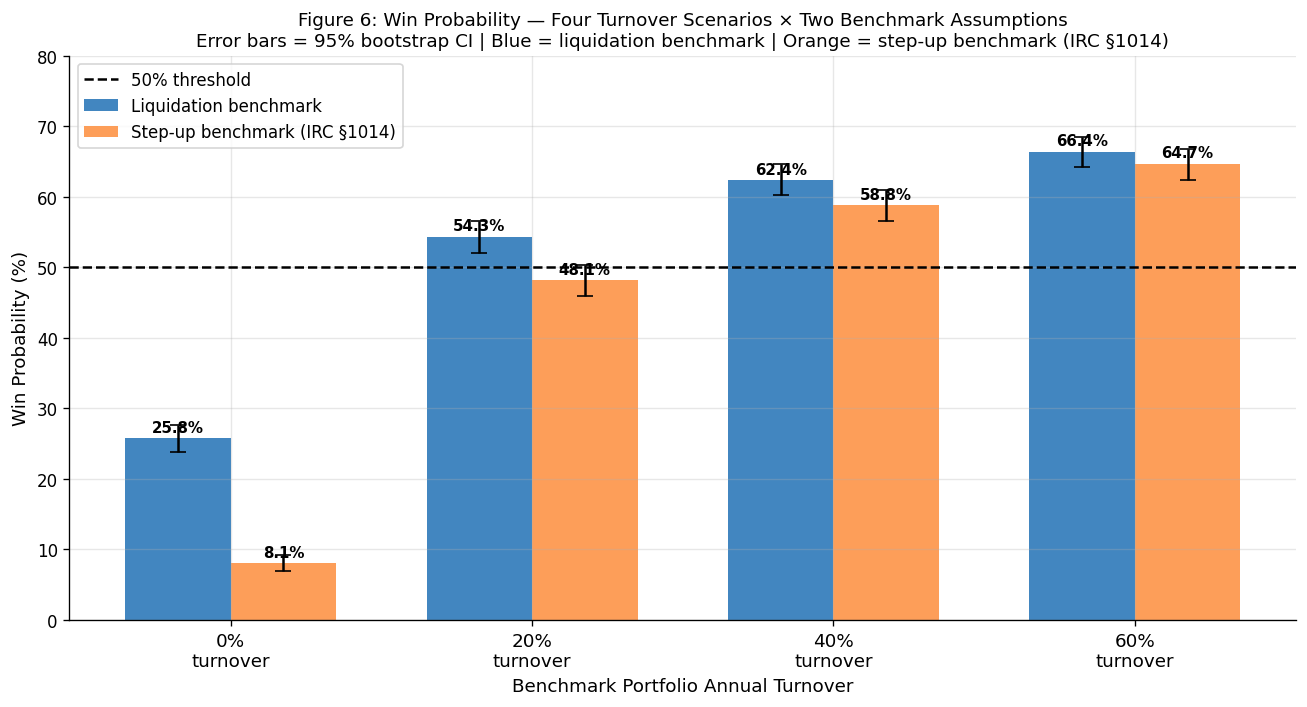

Scenario                              Liq win   Step win      Gap
------------------------------------------------------------------
Scenario A: 0% turnover                 25.8%       8.1%    17.7 pp
Scenario B: 20% turnover                54.3%      48.1%     6.2 pp
Scenario C: 40% turnover                62.4%      58.8%     3.6 pp
Scenario D: 60% turnover                66.4%      64.7%     1.7 pp
Figure 6 saved.


In [9]:
# --- Figure 6: Win probability summary — all four scenarios, both benchmarks ---

# Run step-up versions for comparison
print('Running step-up benchmark for all four scenarios...')
step_up_results = {}
for sc in SCENARIOS:
    p = replace(base_params, turnover=sc['turnover'])
    r = run_simulation(p, step_up=True)
    lo, hi = bootstrap_ci(r['delta_wealth'], lambda x: np.mean(x > 0))
    step_up_results[sc['turnover']] = r
    step_up_results[sc['turnover']]['ci'] = (lo, hi)
    print(f"  {sc['label']}: step-up win={r['win_prob']:.1%}")

print()

# Build figure
fig, ax = plt.subplots(figsize=(11, 6))
x       = np.arange(4)
width   = 0.35
labels  = [f"{sc['turnover']*100:.0f}%\nturnover" for sc in SCENARIOS]

wp_liq  = [scenario_results[sc['turnover']]['win_prob']  * 100 for sc in SCENARIOS]
wp_step = [step_up_results[sc['turnover']]['win_prob']   * 100 for sc in SCENARIOS]
ci_liq  = [scenario_results[sc['turnover']]['ci']              for sc in SCENARIOS]
ci_step = [step_up_results[sc['turnover']]['ci']               for sc in SCENARIOS]

err_liq  = [[wp - ci[0]*100 for wp, ci in zip(wp_liq,  ci_liq)],
            [ci[1]*100 - wp for wp, ci in zip(wp_liq,  ci_liq)]]
err_step = [[wp - ci[0]*100 for wp, ci in zip(wp_step, ci_step)],
            [ci[1]*100 - wp for wp, ci in zip(wp_step, ci_step)]]

bars1 = ax.bar(x - width/2, wp_liq,  width, color='#2171b5', alpha=0.85,
               label='Liquidation benchmark')
bars2 = ax.bar(x + width/2, wp_step, width, color='#fd8d3c', alpha=0.85,
               label='Step-up benchmark (IRC §1014)')
ax.errorbar(x - width/2, wp_liq,  yerr=err_liq,  fmt='none',
            color='black', capsize=5, lw=1.5)
ax.errorbar(x + width/2, wp_step, yerr=err_step, fmt='none',
            color='black', capsize=5, lw=1.5)

# Value labels
for bar, val in zip(bars1, wp_liq):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, wp_step):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.axhline(50, color='black', lw=1.5, ls='--', label='50% threshold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_xlabel('Benchmark Portfolio Annual Turnover', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_ylim(0, 80)
ax.set_title(
    'Figure 6: Win Probability — Four Turnover Scenarios × Two Benchmark Assumptions\n'
    'Error bars = 95% bootstrap CI | '
    'Blue = liquidation benchmark | Orange = step-up benchmark (IRC §1014)',
    fontsize=11
)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('fig6_win_prob_summary.png', bbox_inches='tight', dpi=150)
plt.show()

# Print summary
print(f'{"Scenario":<35} {"Liq win":>9} {"Step win":>10} {"Gap":>8}')
print('-' * 66)
for sc, wl, ws in zip(SCENARIOS, wp_liq, wp_step):
    print(f"{sc['label']:<35} {wl:>8.1f}%  {ws:>8.1f}%  {wl-ws:>6.1f} pp")
print('Figure 6 saved.')

# --- Interpretive note: why the step-up gap is modest (2–17 pp) ---
# Observers often expect the IRC §1014 step-up to devastate CRUT win
# probabilities. Three mechanics explain why the gap is narrower than
# intuition suggests:
#
#   (1) Time value of the terminal tax saving. The step-up eliminates capital
#       gains tax — but only once, at the end of a 30+ year horizon. Discounted
#       back at 5%, a $500K terminal CG liability loses roughly 75% of its
#       present value. The CRUT's charitable deduction, by contrast, is absorbed
#       in the first 1–6 years and is nearly fully present-valued.
#
#   (2) Turnover erodes the embedded gain. At 20%+ turnover the benchmark
#       continuously realizes and pays capital gains throughout the horizon.
#       By death, much of the original embedded gain has already been taxed;
#       there is far less left to forgive at step-up. This explains why the
#       blue-orange gap shrinks as turnover rises.
#
#   (3) Ordinary income drag on CRUT distributions. CRUT payouts are taxed
#       as ordinary income (37% federal + 9.3% CA = 46.3%), while the
#       benchmark's terminal gain would be taxed at only 23.8% (LTCG + NIIT).
#       This ongoing tax burden on distributions partially offsets the CRUT's
#       advantage of deferring — and ultimately avoiding — the initial CG hit.
#
# Together these three effects compress what might appear to be a decisive
# step-up advantage into a modest 2–17 percentage-point reduction in win
# probability across the four turnover scenarios.

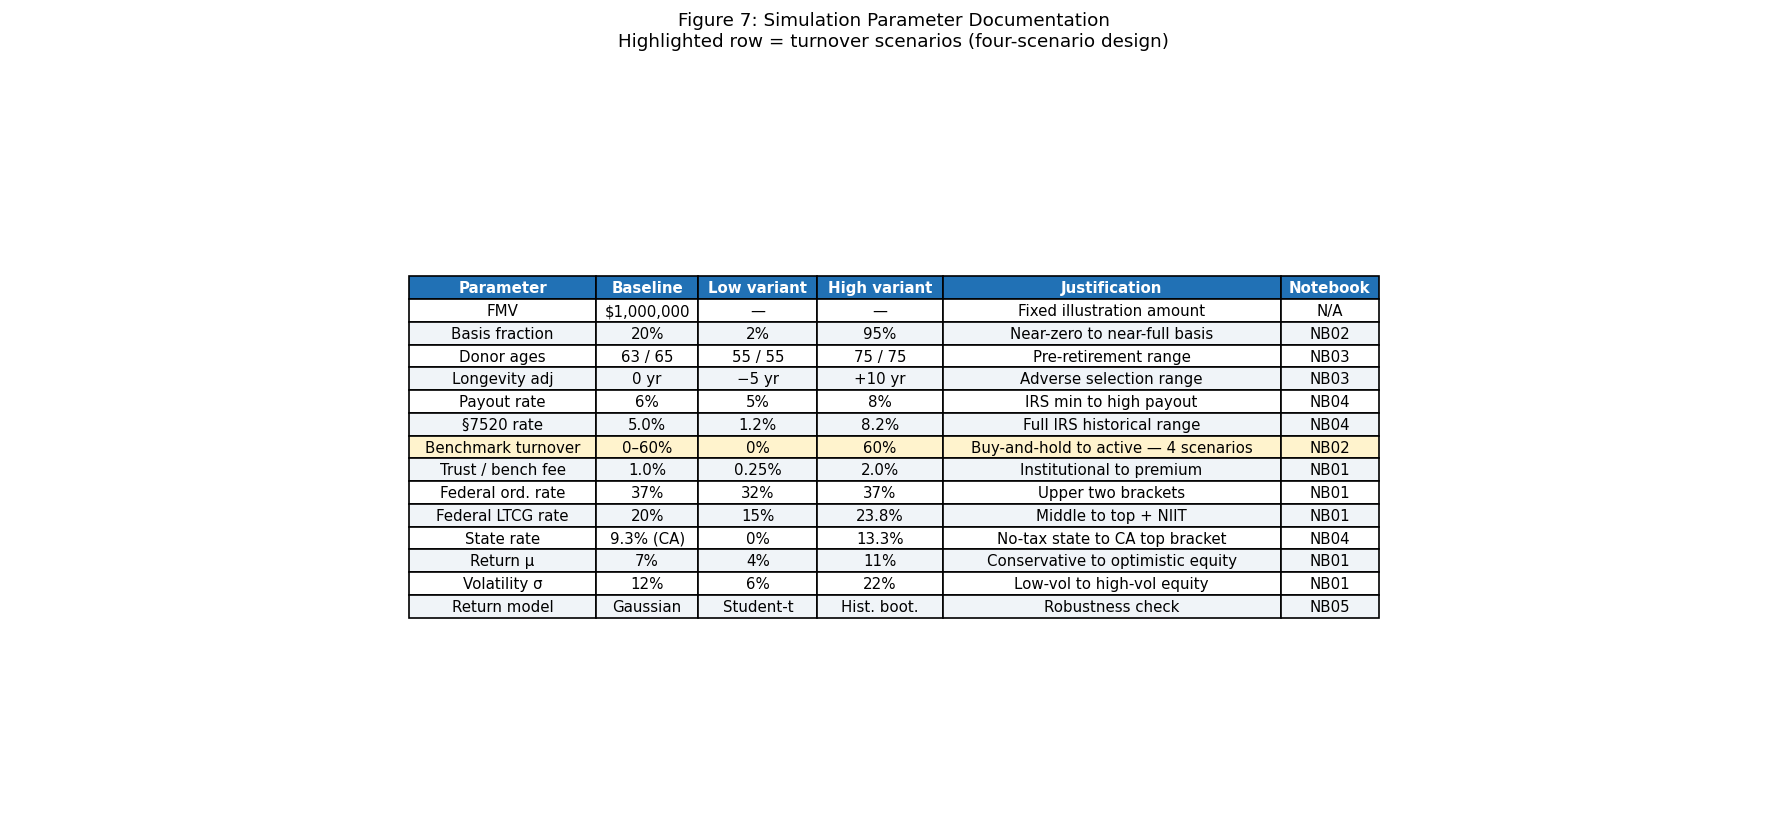

Figure 7 saved.


In [10]:
# --- Figure 7: Parameter documentation table ---
# Records all baseline parameters and their ranges for the sensitivity
# notebooks. This is the methodological reference for the full replication.

param_rows = [
    ['FMV',             '$1,000,000', '—',         '—',           'Fixed illustration amount',        'N/A'],
    ['Basis fraction',  '20%',        '2%',         '95%',         'Near-zero to near-full basis',     'NB02'],
    ['Donor ages',      '63 / 65',    '55 / 55',    '75 / 75',     'Pre-retirement range',             'NB03'],
    ['Longevity adj',   '0 yr',       '−5 yr',      '+10 yr',      'Adverse selection range',          'NB03'],
    ['Payout rate',     '6%',         '5%',         '8%',          'IRS min to high payout',           'NB04'],
    ['§7520 rate',      '5.0%',       '1.2%',       '8.2%',        'Full IRS historical range',        'NB04'],
    ['Benchmark turnover','0–60%',    '0%',         '60%',         'Buy-and-hold to active — 4 scenarios','NB02'],
    ['Trust / bench fee','1.0%',      '0.25%',      '2.0%',        'Institutional to premium',         'NB01'],
    ['Federal ord. rate','37%',       '32%',        '37%',         'Upper two brackets',               'NB01'],
    ['OBBBA ded. rate cap','35%',     '35% (fixed)','37% (pre-law)','One Big Beautiful Bill Act — caps deduction benefit at 35¢/$1 for top bracket','All'],
    ['Federal LTCG rate','20%',       '15%',        '23.8%',       'Middle to top + NIIT',             'NB01'],
    ['State rate',      '9.3% (CA)',  '0%',         '13.3%',       'No-tax state to CA top bracket',   'NB04'],
    ['Return μ',        '7%',         '4%',         '11%',         'Conservative to optimistic equity','NB01'],
    ['Volatility σ',    '12%',        '6%',         '22%',         'Low-vol to high-vol equity',       'NB01'],
    ['Return model',    'Gaussian',   'Student-t',  'Hist. boot.', 'Robustness check',                 'NB05'],
]

col_labels = ['Parameter', 'Baseline', 'Low variant', 'High variant', 'Justification', 'Notebook']

fig, ax = plt.subplots(figsize=(15, 7))
ax.axis('off')
tbl = ax.table(
    cellText=param_rows,
    colLabels=col_labels,
    cellLoc='center', loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.auto_set_column_width(col=list(range(len(col_labels))))

for j in range(len(col_labels)):
    tbl[(0, j)].set_facecolor('#2171b5')
    tbl[(0, j)].set_text_props(color='white', fontweight='bold')
for i in range(1, len(param_rows)+1):
    bg = '#f0f4f8' if i % 2 == 0 else 'white'
    for j in range(len(col_labels)):
        tbl[(i, j)].set_facecolor(bg)

# Highlight the turnover row
tv_row = next(i+1 for i, r in enumerate(param_rows) if 'turnover' in r[0].lower())
for j in range(len(col_labels)):
    tbl[(tv_row, j)].set_facecolor('#fff3cd')

ax.set_title(
    'Figure 7: Simulation Parameter Documentation\n'
    'Highlighted row = turnover scenarios (four-scenario design)',
    fontsize=11, pad=20
)
plt.tight_layout()
plt.savefig('fig7_parameter_table.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 7 saved.')

In [11]:
# =============================================================================
# FINAL SUMMARY — numbers for manuscript Table 1
# =============================================================================

print('=' * 70)
print('NOTEBOOK 00 — BASELINE RESULTS FOR MANUSCRIPT TABLE 1')
print('=' * 70)
print()
print('Liquidation benchmark (donor sells asset, pays LTCG):')
print(f'{"Scenario":<35} {"Win prob":>10} {"95% CI":>20} {"Median ($)":>12}')
print('-' * 82)
for sc in SCENARIOS:
    r = scenario_results[sc['turnover']]
    lo, hi = r['ci']
    print(f"{sc['label']:<35} {r['win_prob']*100:>9.1f}%  "
          f"[{lo*100:.1f}%–{hi*100:.1f}%]  "
          f"${r['median_delta']:>10,.0f}")
print()
print('Step-up benchmark (IRC §1014 — heirs receive reset basis):')
print(f'{"Scenario":<35} {"Win prob":>10} {"95% CI":>20} {"Median ($)":>12}')
print('-' * 82)
for sc in SCENARIOS:
    r = step_up_results[sc['turnover']]
    lo, hi = r['ci']
    print(f"{sc['label']:<35} {r['win_prob']*100:>9.1f}%  "
          f"[{lo*100:.1f}%–{hi*100:.1f}%]  "
          f"${r['median_delta']:>10,.0f}")

print()
print('Deduction analysis (same across all turnover scenarios):')
r0 = list(scenario_results.values())[0]
ded = r0['deduction_res']
print(f'  Charitable deduction:   ${ded["deduction"]:>10,.0f}')
print(f'  Remainder factor:       {ded["remainder_factor"]:>10.4f}')
print(f'  10% test compliance:    {str(ded["compliance"]):>10}')
print(f'  IRS actuarial duration: {ded["irs_duration"]:>10.1f} years')
print(f'  Simulation horizon:     {r0["T"]:>10} years')
print(f'  PV of tax benefit:      ${r0["pv_tax"]:>10,.0f}')
print()

import os
figures = ['fig1_2_fan_charts.png', 'fig3_terminal_distributions.png',
           'fig4_cdfs.png', 'fig5_annual_distributions.png',
           'fig6_win_prob_summary.png', 'fig7_parameter_table.png']
print('Figure completion check:')
for f in figures:
    print(f"  {'OK' if os.path.exists(f) else 'MISSING'} {f}")
print()
print('Notebook 00 complete. Proceed to Notebook 01 — Sensitivity Analysis.')

NOTEBOOK 00 — BASELINE RESULTS FOR MANUSCRIPT TABLE 1

Liquidation benchmark (donor sells asset, pays LTCG):
Scenario                              Win prob               95% CI   Median ($)
----------------------------------------------------------------------------------
Scenario A: 0% turnover                  25.8%  [23.8%–27.6%]  $  -184,046
Scenario B: 20% turnover                 54.3%  [52.0%–56.6%]  $    19,397
Scenario C: 40% turnover                 62.4%  [60.2%–64.6%]  $    51,876
Scenario D: 60% turnover                 66.4%  [64.2%–68.5%]  $    65,899

Step-up benchmark (IRC §1014 — heirs receive reset basis):
Scenario                              Win prob               95% CI   Median ($)
----------------------------------------------------------------------------------
Scenario A: 0% turnover                   8.1%  [6.9%–9.2%]  $  -530,582
Scenario B: 20% turnover                 48.1%  [46.0%–50.3%]  $   -10,692
Scenario C: 40% turnover                 58.8%  [56.6%–